In [319]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


In [320]:
from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer




# Проект 5. Компьютер говорит «Нет» 

##### Вам предоставлена информация из анкетных данных заемщиков и факт наличия дефолта.

Описания полей client_id - идентификатор клиента

education - уровень образования

sex - пол заемщика

age - возраст заемщика

car - флаг наличия автомобиля

car_type - флаг автомобиля иномарки

decline_app_cnt - количество отказанных прошлых заявок

good_work - флаг наличия “хорошей” работы

bki_request_cnt - количество запросов в БКИ

home_address - категоризатор домашнего адреса

work_address - категоризатор рабочего адреса

income - доход заемщика

foreign_passport - наличие загранпаспорта

sna - связь заемщика с клиентами банка

first_time - давность наличия информации о заемщике

score_bki - скоринговый балл по данным из БКИ

region_rating - рейтинг региона

app_date - дата подачи заявки

default - флаг дефолта по кредиту

##### Цель: построить скоринг модель для вторичных клиентов банка, которая бы предсказывала вероятность дефолта клиента.

In [321]:
#загрузим данные
data = pd.read_csv('../input/sf-dst-scoring/train.csv')
test = pd.read_csv('../input/sf-dst-scoring/test.csv')
submission = pd.read_csv('../input/sf-dst-scoring/sample_submission.csv')
#data = data.drop('app_date',axis=1)

In [322]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
#data['sample'] = 1  
#test['sample'] = 0
#test['default'] = 0
#data = test.append(train, sort=False).reset_index(drop=True)
# объединяем

### Проведем разведывательный анализ данных и обработаем признаки

In [323]:
# посмотрим на данные
data.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [324]:
display(data.info())
display(data.describe())
display(data.describe(include = ['object']))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   education         73492 non-null  object 
 2   sex               73799 non-null  object 
 3   age               73799 non-null  int64  
 4   car               73799 non-null  object 
 5   car_type          73799 non-null  object 
 6   decline_app_cnt   73799 non-null  int64  
 7   good_work         73799 non-null  int64  
 8   score_bki         73799 non-null  float64
 9   bki_request_cnt   73799 non-null  int64  
 10  region_rating     73799 non-null  int64  
 11  home_address      73799 non-null  int64  
 12  work_address      73799 non-null  int64  
 13  income            73799 non-null  int64  
 14  sna               73799 non-null  int64  
 15  first_time        73799 non-null  int64  
 16  foreign_passport  73799 non-null  object

None

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default
count,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000
mean,55137.965094,39.280641,0.275749,0.164894,-1.904724,2.000339,56.725701,1.575509,2.496280,41099.775417,1.733330,2.765458,0.126994
std,31841.921168,11.520378,0.804272,0.371087,0.498231,2.252073,13.055717,0.527631,0.689818,46166.322400,1.123622,1.009463,0.332968
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,0.000000
25%,27440.500000,30.000000,0.000000,0.000000,-2.259534,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,0.000000
50%,55274.000000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,0.000000
75%,82758.500000,48.000000,0.000000,0.000000,-1.569831,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,0.000000
max,110147.000000,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000


,education,sex,car,car_type,foreign_passport
count,73492,73799,73799,73799,73799
unique,5,2,2,2,2
top,SCH,F,N,N,N
freq,38860,41562,49832,59791,62733


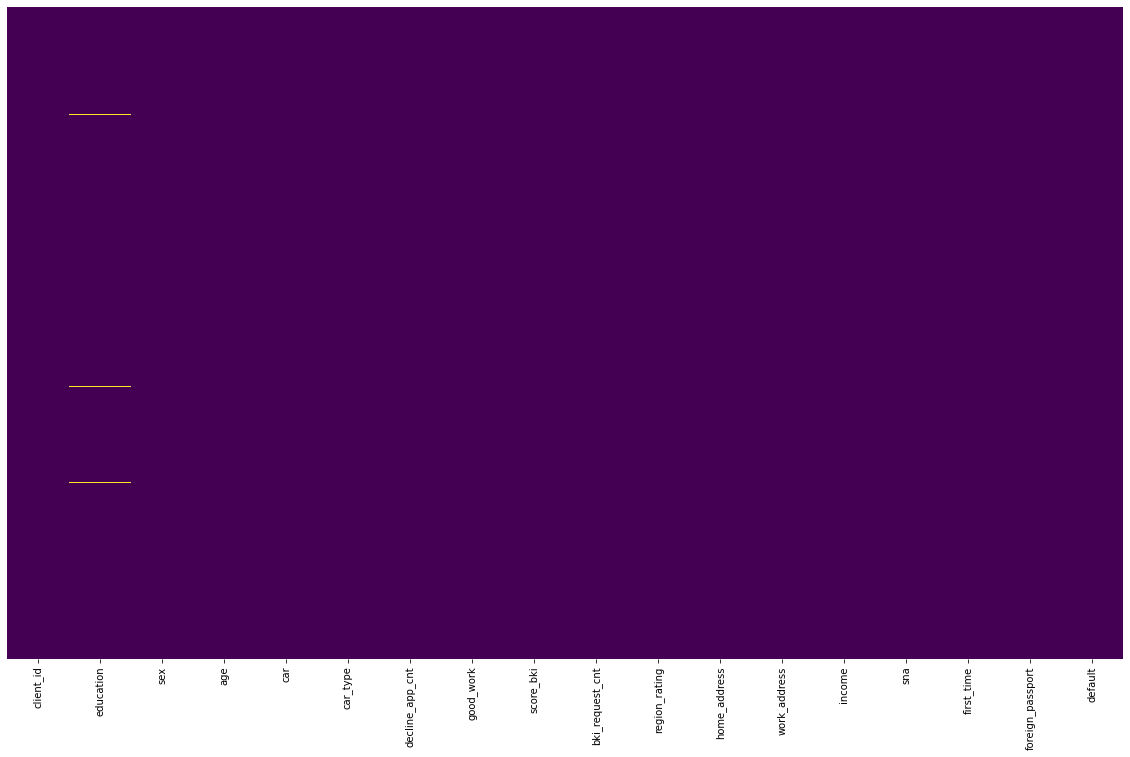

In [325]:
fig, ax = plt.subplots(figsize=(20, 12))
sns_heatmap = sns.heatmap(
    data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

##### Итого:

Всего данные о 110148 клиентах. Всего 20 колонок, из них 6 типа object;
из них:
sex, car, car_type, foreign_passport - скорее всего бинарные;
education, work_address, home_address, sna, first_time, region_rating, app_date - gпохожи на категориальные признаки;
age, decline_app_cnt, income, bki_request_cnt, score_bki - числовые4
Cудя по min и max значениям явных выбросов нет;
Все пропуски только в одном столбце - education, наиболее частое значение SCH;

In [326]:
data.sample(5)

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
21891,44439,GRD,F,42,N,N,0,0,-0.926302,24,50,1,2,80000,1,3,N,0
5504,10446,SCH,M,35,N,N,1,0,-2.240495,4,40,1,2,13000,1,4,N,0
35377,93726,UGR,F,39,N,N,0,0,-0.015117,0,40,2,3,32000,4,2,N,0
52555,101077,UGR,F,59,N,N,0,0,-1.493032,5,60,1,2,24000,1,4,Y,0
17917,51653,SCH,F,33,N,N,0,0,-2.034114,0,60,2,3,17000,1,3,N,0


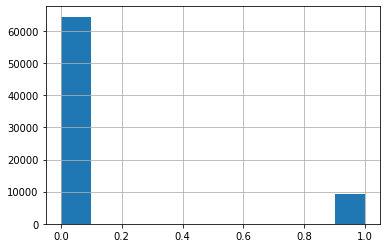

In [327]:
# посмотрим количество недобросовестных клиентов
data.default.hist();

большинство клиентов добросовестные, выборка не слишком сбалансирована,
но наверное это отражает реальную ситуацию

In [328]:
#так как в признаке education пропусков не так много, 
#то заполним их самым часто встречающимся значением, то есть SCH
data['education'] = data['education'].fillna(data['education'].mode()[0])

In [329]:
#разделим наши признаки по группам

In [330]:
# бинарные переменные
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

# категориальные переменные
cat_cols = ['education', 'work_address', 'home_address', 'sna', 'first_time', 'region_rating']

# числовые переменные
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki']


#### Рассмотрим числовые признаки

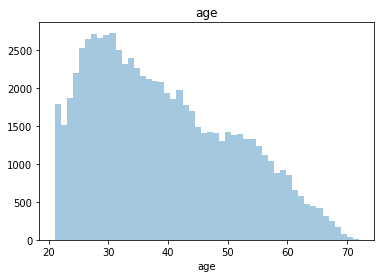

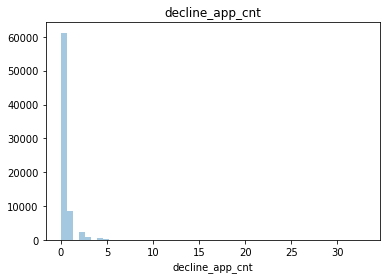

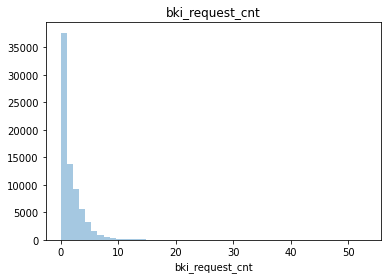

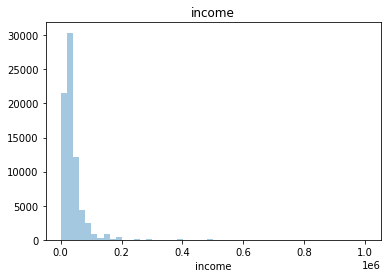

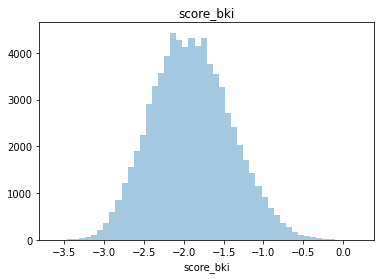

In [331]:
for i in num_cols:
    plt.figure()
    sns.distplot(data[i], kde=False, rug=False)
    plt.title(i)
    plt.show()

In [332]:
#отметим, что score_bki может быть отрицательным и у него нормальное распределение

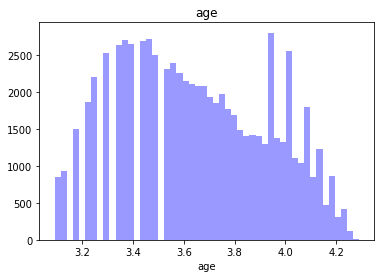

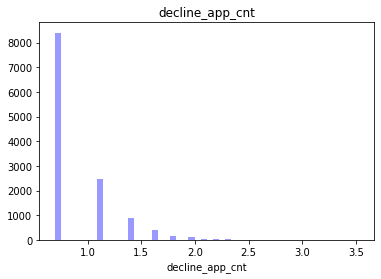

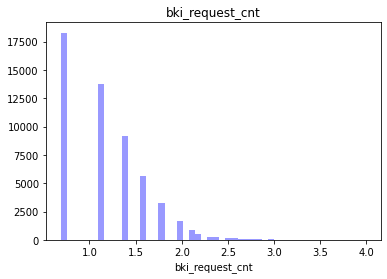

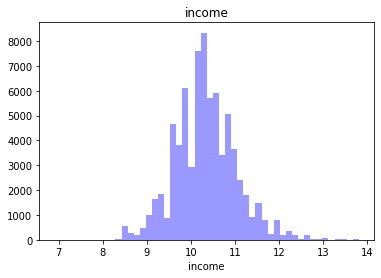

In [333]:
# логарифмируем остальные числовые переменные
log_num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']

for i in log_num_cols:
    #зачем к логарифму добавляем 1 - чтобы если в df[i] был 0, то натуральный логарифм нуля - минус бесконечность
    data[i] = np.log(data[i]+1)
    plt.figure()
    sns.distplot(data[i][data[i] > 0].dropna(), kde = False, rug=False, color='b')
    plt.title(i)
    plt.show()

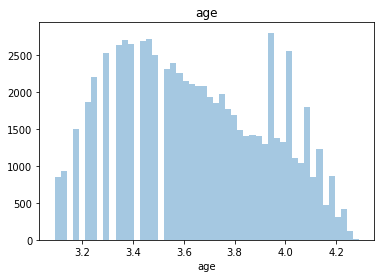

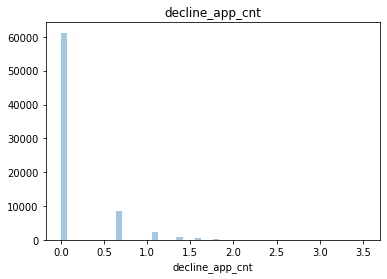

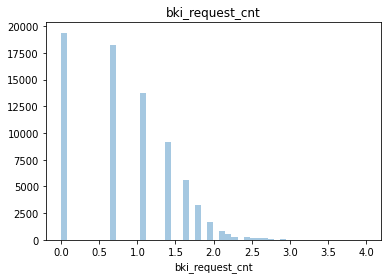

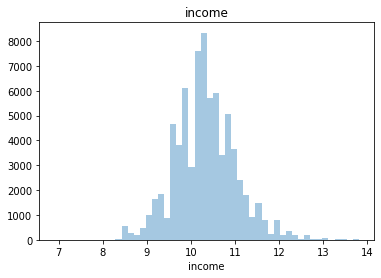

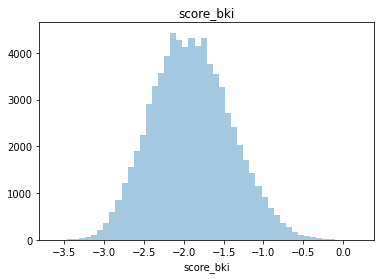

In [334]:
# проверим, что получилось и перезапишем список с числовыми признаками
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki']

for i in num_cols:
    plt.figure()
    sns.distplot(data[i], kde=False, rug=False)
    plt.title(i)
    plt.show()

In [335]:
# результат есть только для признака income

<AxesSubplot:>

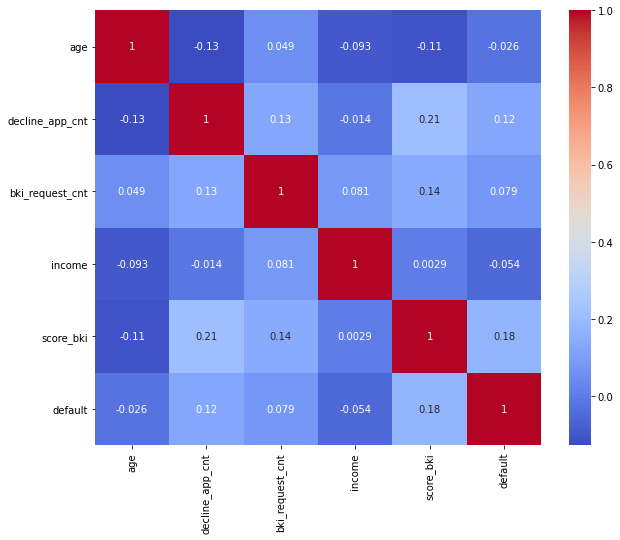

In [336]:
# построим матрицу корреляций для числовых признаков
plt.figure(figsize=(10,8))
sns.heatmap(data[num_cols+['default']].corr(), cmap='coolwarm', annot=True)

In [337]:
data[num_cols].corr()

,age,decline_app_cnt,bki_request_cnt,income,score_bki
age,1.000000,-0.127734,0.049327,-0.092586,-0.109971
decline_app_cnt,-0.127734,1.000000,0.125163,-0.013868,0.210090
bki_request_cnt,0.049327,0.125163,1.000000,0.081019,0.139622
income,-0.092586,-0.013868,0.081019,1.000000,0.002860
score_bki,-0.109971,0.210090,0.139622,0.002860,1.000000


Взаимосвязь слабая. Максимальный коэффициент 0.21. Мультиколлинеарность отсутствует, оставляем все числовые признаки для модели

<AxesSubplot:>

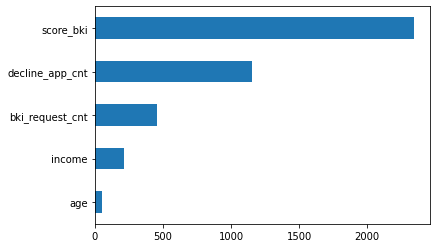

In [338]:
# Значимость непрерывных переменных
imp_num = Series(f_classif(data[num_cols], data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

отметим, что f-статистики income и age такими не являются важными признаками. 

#### Рассмотрим бинарные переменные

In [339]:
# Для бинарных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
    
# убедимся в преобразовании    
data.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,SCH,1,4.143135,1,1,0.000000,0,-2.008753,0.693147,50,1,2,9.798183,4,1,0,0
1,63161,SCH,0,4.094345,0,0,0.000000,0,-1.532276,1.386294,50,2,3,9.852247,4,1,0,0
2,25887,SCH,1,3.258097,1,0,1.098612,0,-1.408142,0.693147,80,1,2,10.308986,1,4,1,0
3,16222,SCH,0,3.988984,0,0,0.000000,0,-2.057471,1.098612,50,2,3,9.210440,1,3,0,0
4,101655,GRD,1,3.891820,0,0,0.000000,1,-1.244723,0.693147,60,2,3,10.308986,1,4,1,0


#### Рассмотрим категориальные переменные

In [340]:
# Для категориальных признаков мы будем использовать OneHotEncoder
X_cat = pd.get_dummies(data, columns = cat_cols)

In [341]:
#переводим признак education в численный формат
data['education'] = label_encoder.fit_transform(data['education'])

<AxesSubplot:>

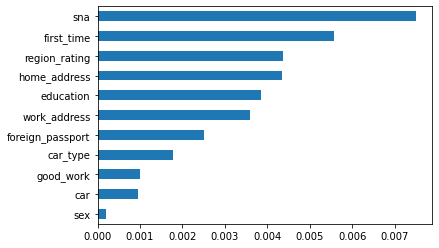

In [342]:
imp_cat = Series(mutual_info_classif(data[bin_cols + cat_cols], data['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

обратим внимание, что признаки sex, car, good_work, car_type не являются особо значимыми признаками. 

In [343]:
# попробуем стандартизировать часть числовых признаков
num_cols = ['decline_app_cnt', 'bki_request_cnt', 'score_bki']

In [344]:
scaler = RobustScaler() 
X_num = scaler.fit_transform(data[num_cols].values)

In [345]:
data

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,3,1,4.143135,1,1,0.000000,0,-2.008753,0.693147,50,1,2,9.798183,4,1,0,0
1,63161,3,0,4.094345,0,0,0.000000,0,-1.532276,1.386294,50,2,3,9.852247,4,1,0,0
2,25887,3,1,3.258097,1,0,1.098612,0,-1.408142,0.693147,80,1,2,10.308986,1,4,1,0
3,16222,3,0,3.988984,0,0,0.000000,0,-2.057471,1.098612,50,2,3,9.210440,1,3,0,0
4,101655,1,1,3.891820,0,0,0.000000,1,-1.244723,0.693147,60,2,3,10.308986,1,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73794,54887,1,0,3.828641,0,0,0.000000,0,-1.792064,1.386294,50,1,2,9.741027,4,4,0,0
73795,76821,3,1,3.737670,1,1,0.000000,0,-2.058029,0.693147,50,2,2,11.156265,1,4,0,0
73796,103695,3,1,3.465736,0,0,0.000000,0,-1.512635,1.609438,80,2,3,10.714440,2,2,0,0
73797,861,3,0,3.401197,0,0,0.000000,1,-1.479334,1.386294,50,1,3,9.472782,2,3,0,1


In [346]:
X_cat = pd.DataFrame(OneHotEncoder(sparse = False).fit_transform(data[cat_cols].values))
data = pd.concat([data, X_cat], axis=1).drop(cat_cols, axis=1)
len(data.columns)

38

### Постороим наивную модель и попробуем улучшить

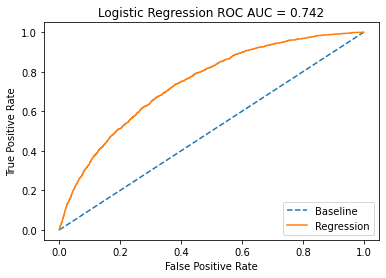

In [347]:
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train, y_train)

#predict_proba - Probability estimates.
probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
# [0, 1] чтобы график был в пространстве от 0 до 1, по типу диагонали
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Без подбора гиперпараметров значение на kaggle получилось 0.5

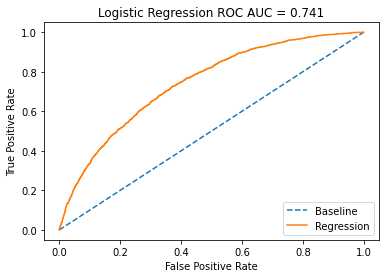

In [348]:
model = LogisticRegression(penalty='l2', C=7.742636826811269, solver ='saga', class_weight='balanced', max_iter=100, random_state=42)
model.fit(X_train, y_train)

#predict_proba - Probability estimates.
probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
# [0, 1] чтобы график был в пространстве от 0 до 1, по типу диагонали
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

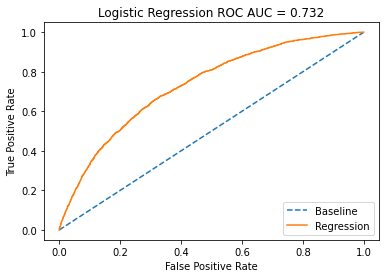

In [349]:
clf = LogisticRegressionCV(cv=5, random_state=42).fit(X_train, y_train)
#predict_proba - Probability estimates.
probs = clf.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
# [0, 1] чтобы график был в пространстве от 0 до 1, по типу диагонали
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

#### Обрабатываем тестовую выборку, загружаем в модель и готовим submission

In [358]:
true_test = pd.read_csv('../input/sf-dst-scoring/test.csv')

In [359]:
true_test.drop(['app_date'], axis = 1, inplace=True)

In [360]:
true_test.sample(5)

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
16080,55738,SCH,F,55,N,N,0,0,-0.919055,3,70,2,3,15000,1,3,N
3143,79984,UGR,F,35,N,N,0,0,-2.244917,2,50,1,2,12000,1,2,N
12068,63008,GRD,F,49,N,N,0,0,-1.550502,1,40,2,3,60000,3,4,N
5597,48910,SCH,F,61,N,N,0,0,-2.173411,4,60,2,3,12300,4,1,N
31589,65919,SCH,M,21,N,N,2,0,-1.183357,3,50,2,3,50000,4,1,N


In [361]:
true_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   education         36178 non-null  object 
 2   sex               36349 non-null  object 
 3   age               36349 non-null  int64  
 4   car               36349 non-null  object 
 5   car_type          36349 non-null  object 
 6   decline_app_cnt   36349 non-null  int64  
 7   good_work         36349 non-null  int64  
 8   score_bki         36349 non-null  float64
 9   bki_request_cnt   36349 non-null  int64  
 10  region_rating     36349 non-null  int64  
 11  home_address      36349 non-null  int64  
 12  work_address      36349 non-null  int64  
 13  income            36349 non-null  int64  
 14  sna               36349 non-null  int64  
 15  first_time        36349 non-null  int64  
 16  foreign_passport  36349 non-null  object

In [362]:
true_test['education'] = true_test['education'].fillna(true_test['education'].mode()[0])

In [363]:
X_num_test = scaler.transform(true_test[num_cols].values)


In [366]:
X_cat_test = OneHotEncoder(sparse = False).fit_transform(true_test[cat_cols].values)

In [367]:
label_encoder = LabelEncoder()

for column in bin_cols:
    true_test[column] = label_encoder.fit_transform(true_test[column])
    
# убедимся в преобразовании    
true_test.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,GRD,1,29,1,1,0,0,-2.271884,3,50,1,2,50000,1,4,0
1,17527,SCH,0,39,0,0,5,0,-1.504999,2,50,1,2,5000,4,3,0
2,75683,UGR,1,50,1,1,0,0,-1.691339,1,50,1,2,30000,1,3,1
3,26883,SCH,1,56,0,0,0,0,-2.374182,1,40,1,2,17000,1,3,0
4,28862,GRD,0,38,0,0,0,0,-2.487502,0,80,2,3,120000,1,3,0


In [368]:
upd_true_test = np.hstack([X_num_test, true_test[bin_cols].values, X_cat_test])

In [370]:
predict_submission = model.predict(upd_true_test)

In [371]:
true_test['default'] = predict_submission

In [372]:
submission = true_test[['client_id', 'default']]

In [373]:
submission.to_csv('submission.csv', index=False)
submission.head(10)


,client_id,default
0,74835,0
1,17527,1
2,75683,0
3,26883,0
4,28862,0
5,99881,1
6,26630,1
7,79934,0
8,16605,0
9,105449,0


In [374]:
submission.shape

(36349, 2)

In [354]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  73799 non-null  int64
 1   default    73799 non-null  int64
dtypes: int64(2)
memory usage: 1.1 MB
